# Looking at MoCHI results (notebook M1, 08.03.2024) on DTS (Combinatorial) datasets

1. Allowing for up to 2nd order terms
2. Fitting using Sigmoid function
3. Using `l2_regularization_factor` parameter = 10^(-5)

11.03.2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from pymochi.models import MochiTask

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
results_dir = '/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/amyloids_energy_modelling/Combinatorial_mutants_analysis/mochi_results/'


In [4]:
filedir = '/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/amyloids_energy_modelling/Combinatorial_mutants_analysis/files/'

datasets = ['DTS01',
            'DTS05',
           ]

filenames = {}

for dataset in datasets:
    filenames[dataset] = 'mochi_all_variants_' + dataset + '_20240424.tsv'

output_dir = '/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/DTS_joint_analysis/mochi_results/'

In [6]:
l2_regularisation_factor_value = '1e-05'

transformations = ['Sigmoid',
                  ] 


In [7]:
predictions = {}

mochi_tasks = {}

for transformation in transformations: 
    print(transformation)
    
    curr_path = results_dir + '20240424_max_terms_order_2_' + transformation + '_l2_regularization_factor_' + l2_regularisation_factor_value + '_DTS01_DT05_all_variants/'

    #curr_paths_indiv_models = 
    curr_key = transformation + '_DTS01_DT05_all_variants_1st_and_2nd_order'

    predictions[curr_key] = pd.read_csv(curr_path + '/predictions/predicted_phenotypes_all.txt',
                                                                       sep='\t') 
    predictions[curr_key].phenotype = [str(i) for i in predictions[curr_key].phenotype]

    # adding a column with residual values
    observed_phenotype_col = 'fitness'
    predicted_phenotype_col = 'fold_1'
    residuals_col = 'residual_pred_vs_obs'
    predictions[curr_key][residuals_col] = predictions[curr_key][predicted_phenotype_col] - predictions[curr_key][observed_phenotype_col]


    # loading previous task / model to have some of the parameters here
    mochi_tasks[curr_key] = MochiTask(directory = curr_path)
    
    # rescaling energies to be in kcal/mol
    # scaling twice
    # using slope and intercept bw DTS and doubles common terms derived in notebook M3
    
    intercept_value = -0.15589508632224625
    slope_value = 0.41604357
    
    all_folds = [int(i) for i in list(set(predictions[curr_key].loc[predictions[curr_key].Fold.isna()==False,'Fold']))]
    for fold in all_folds:
        predictions[curr_key]['fold_' + str(fold) + '_additive_trait0'] = (predictions[curr_key]['fold_' + str(fold) + '_additive_trait0'] + intercept_value)/(-slope_value)
        


Sigmoid


In [8]:
predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order'].columns

Index(['aa_seq', 'Nham_aa', 'WT', 'fitness', 'sigma', 'phenotype',
       'Nucleation_DTS01', 'Nucleation_DTS05', 'fold_1', 'fold_2', 'fold_3',
       'fold_4', 'fold_5', 'fold_6', 'fold_7', 'fold_8', 'fold_9', 'fold_10',
       'mean', 'std', 'ci95', 'Fold', 'fold_1_additive_trait0',
       'fold_2_additive_trait0', 'fold_3_additive_trait0',
       'fold_4_additive_trait0', 'fold_5_additive_trait0',
       'fold_6_additive_trait0', 'fold_7_additive_trait0',
       'fold_8_additive_trait0', 'fold_9_additive_trait0',
       'fold_10_additive_trait0', 'residual_pred_vs_obs'],
      dtype='object')

In [9]:
type(predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order'].phenotype[0])

str

In [10]:
# importing plotting function from MoCHI for predicted vs observed phenotype
def plot_test_performance_multiplot(
        #self,
        input_df,
    axis,
    Title=None,
        #output_path_prefix
):
        """
        Plot model performance on test data.

        :param input_df: Input DataFrame with all predictions (required).
        :param output_path_prefix: Output file path (required).
        :returns: Nothing.
        """ 

        #Subset to held out variants and relevant columns
        all_folds = [int(i) for i in list(set(input_df.loc[input_df.Fold.isna()==False,'Fold']))]
        all_folds = [i for i in all_folds if 'fold_'+ str(i) in input_df.columns] 
        rel_cols = ['fitness', 'phenotype', 'Fold']+['fold_'+str(i) for i in all_folds]
        result_df = input_df.loc[input_df.Fold.isna()==False,rel_cols]
        
        #Observed phenotype
        result_df['Observed phenotype'] = result_df['fitness']
        
        #Predicted phenotype
        for i in all_folds:
            result_df.loc[result_df.Fold==i,'Predicted phenotype'] = result_df.loc[result_df.Fold==i,'fold_'+str(i)]

        #Plot performance for all phenotypes
        for i in list(set(result_df.phenotype)):
            #Plot
            plot_df = result_df.loc[result_df.phenotype==i,:]
            #fig, ax = plt.subplots()  # Create a figure containing a single axes.
            plot_df.reset_index(drop = True, inplace = True)
            n_bin = 50
            cmap = LinearSegmentedColormap.from_list('whiteblack', ['white', 'black'], N=n_bin)
            z = axis.hexbin(
                x = 'Observed phenotype',
                y = 'Predicted phenotype',
                data = plot_df, gridsize = 100, cmap = cmap, bins = 'log')
            #Color scale
            plt.colorbar(z, ax=axis
                        )
            #Guides
            axis.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black')
            axis.axhline(y = 0, color = 'black', linestyle = '--')
            axis.axvline(x = 0, color = 'black', linestyle = '--')
            #Labels
            #axis.set_title(self.task.data.phenotype_names[int(i)-1])
            #plt.xlabel('Observed phenotype', size = 14)
            #plt.ylabel('Predicted phenotype', size = 14)
            axis.set_aspect("equal")
            #R-squared
            from matplotlib.offsetbox import AnchoredText
            cor_coef = np.corrcoef(
                result_df.loc[result_df.phenotype==i,'Observed phenotype'], 
                result_df.loc[result_df.phenotype==i,'Predicted phenotype'])[0,1]
            at = AnchoredText(
                r'$R^2 = $'+str(round(np.power(cor_coef, 2), 2)), 
                prop=dict(size=14), frameon=False, loc='upper left')
            axis.text(0.5,-3,r'$R^2 = $'+str(round(np.power(cor_coef, 2), 2)))
            axis.title.set_text(Title)
            #plt.show()
            #Save
            #plt.savefig(output_path_prefix+self.task.data.phenotype_names[int(i)-1]+".pdf")

## Results here will be plotted for each of the datasets' predictions

For 2 phenotypes/datasets:
- DTS01 (Combinatorial-1)
- DTS05 (Combinatorial-2)

In [13]:
l2_regularisation_factor_values = ['1e-05']

# Global epistasis plots

In [14]:
def plot_observed_phenotype_vs_additivetrait_multiplot(
        #self,
        input_df,
        run_key, # Linear_not_dead; etc, the model run (transformation + file handle) 
        #output_path_prefix,
        phenotype, # phenotype value (str) from input_df['phenotype'] to plot stuff for
        axis,
        transformation = None,
        Title = None,
        folds = None,
        RT = None):
        """
        Plot observed phenoypte versus additive trait (1-dimensional additive traits only).

        :param input_df: Input DataFrame with all predictions (required).
        :param output_path_prefix: Output file path (required).
        :param folds: list of cross-validation folds (default:None i.e. all).
        :param RT: R=gas constant (in kcal/K/mol) * T=Temperature (in K) (optional).
        :returns: Nothing.
        """ 
        #Set folds if not supplied
        if folds==None:
            folds = [i+1 for i in range(mochi_tasks[run_key].data.k_folds)]

        #Set RT if not supplied
        if RT==None:
            RT = 1

        fold = folds[0] # it is 1 now
        observed_phenotype_col = 'fitness'

        #Plot performance for all 1-dimensional phenotypes
        
        i = int(phenotype) - 1 # phenotype counter, for phenotype 1 should be 0, and so on
                
        if len(mochi_tasks[run_key].data.model_design.loc[i,'trait'])==1:
            predicted_phenotype_col = 'fold_'+str(fold)
            additive_trait_col = predicted_phenotype_col+'_additive_trait0' # this will be 'fold_1_additive_trait0'
            # sort by fold_1_additive_trait0
            plot_df_sort = input_df.loc[input_df.phenotype==str(i+1),:].sort_values(additive_trait_col)
            plot_df_sort.reset_index(drop = True, inplace = True)
                
            
            #Convert units
            plot_df_sort[additive_trait_col+"_kcal/mol"] = plot_df_sort[additive_trait_col]*RT
            additive_trait_col = additive_trait_col+"_kcal/mol"
            #fig, ax = plt.subplots()
            n_bin = 50
            cmap = LinearSegmentedColormap.from_list('whiteblack', ['white', 'black'], N=n_bin)
            
            z = axis.hexbin(
                    x = additive_trait_col,
                    y = observed_phenotype_col,
                    data = plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),:], gridsize = 100, cmap = cmap, bins = 'log')
            axis.plot(
                    plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),additive_trait_col], 
                    plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),predicted_phenotype_col], mfc='none', 
                    linestyle = "-", color = 'red'
                )
            #Color scale
            plt.colorbar(z, ax=axis)
            #Guides
            axis.axhline(y = 0, color = 'black', linestyle = '--')
            axis.axvline(x = 0, color = 'black', linestyle = '--')
                
            #Labels
            #ax.set_title(mochi_tasks[run_key].data.phenotype_names[int(i)])
            axis.set_title(Title, fontsize = 10)
            if transformation != None:
                axis.set_ylabel(str(transformation) + '\n transformation', size = 14)
            #axis.set_xlabel('Additive trait (-dEa)', size = 14)
            #Save
            #plt.savefig(output_path_prefix+self.task.data.phenotype_names[int(i)]+".pdf")

In [15]:
phenotypes = np.unique(predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order']['phenotype'])

In [16]:
phenotypes

array(['1', '2'], dtype=object)

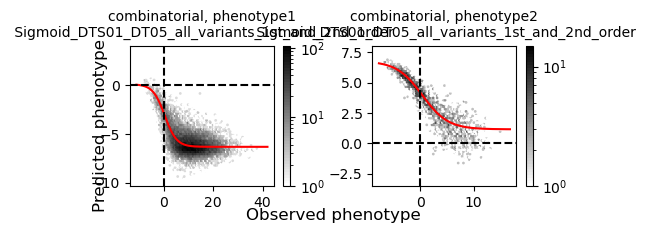

In [18]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

# only plotting for Sigmoid

transformations = ['Sigmoid']

fig, axs = plt.subplots(len(l2_regularisation_factor_values), len(phenotypes),
                        figsize=(5, 2), squeeze=False)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

fig.supxlabel('Observed phenotype')
fig.supylabel('Predicted phenotype')

    

for i in range(len(phenotypes)):
    
    # plotting for each dataset
    curr_phenotype = phenotypes[i] # eLife is 1, NNK (C-term) is 2, Nicking (N-term) is 3

    curr_transformation = 'Sigmoid'
    
    for j in range(len(l2_regularisation_factor_values)):
        #print(j)
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        curr_key = 'Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order'
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions[curr_key]
        curr_predictions_selected = curr_predictions_all[curr_predictions_all['phenotype'] == curr_phenotype]
        #curr_predictions_2 = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        #curr_predictions_3 = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_observed_phenotype_vs_additivetrait_multiplot(curr_predictions_selected,
                                run_key=curr_key,
                                axis=axs[j, i], phenotype=curr_phenotype,
                                 Title = 'combinatorial, phenotype' + curr_phenotype + '\n ' + curr_key)
        
#plt.savefig('./figures/20240718_mochi_observed_phenotype_vs_additivetrait_Nucleation_DTS01_DTS01.pdf',
#            bbox_inches = 'tight')

    


# Residuals plots

In [19]:
def plot_residuals_multiplot(
        #self,
        input_df,
        run_key, # Linear_not_dead; etc, the model run (transformation + file handle) 
        #output_path_prefix,
        phenotype, # phenotype value (str) from input_df['phenotype'] to plot stuff for
        axis,
        transformation = None,
        Title = None,
        folds = None,
        RT = None):
        """
        Plot observed phenoypte versus additive trait (1-dimensional additive traits only).

        :param input_df: Input DataFrame with all predictions (required).
        :param output_path_prefix: Output file path (required).
        :param folds: list of cross-validation folds (default:None i.e. all).
        :param RT: R=gas constant (in kcal/K/mol) * T=Temperature (in K) (optional).
        :returns: Nothing.
        """ 
        #Set folds if not supplied
        if folds==None:
            folds = [i+1 for i in range(mochi_tasks[run_key].data.k_folds)]

        #Set RT if not supplied
        if RT==None:
            RT = 1

        fold = folds[0] # it is 1 now
        observed_phenotype_col = 'fitness'

        #Plot performance for all 1-dimensional phenotypes
        
        i = int(phenotype) - 1 # phenotype counter, for phenotype 1 should be 0, and so on
                
        if len(mochi_tasks[run_key].data.model_design.loc[i,'trait'])==1:
            predicted_phenotype_col = 'fold_'+str(fold)
            additive_trait_col = predicted_phenotype_col+'_additive_trait0' # this will be 'fold_1_additive_trait0'
            # sort by fold_1_additive_trait0
            plot_df_sort = input_df.loc[input_df.phenotype==str(i+1),:].sort_values(additive_trait_col)
            plot_df_sort.reset_index(drop = True, inplace = True)
                
            
            #Convert units
            plot_df_sort[additive_trait_col+"_kcal/mol"] = plot_df_sort[additive_trait_col]*RT
            additive_trait_col = additive_trait_col+"_kcal/mol"
            residuals_col = 'residual_obs_vs_pred'
            #fig, ax = plt.subplots()
            n_bin = 50
            cmap = LinearSegmentedColormap.from_list('whiteblack', ['white', 'black'], N=n_bin)
            
            z = axis.hexbin(
                    x = additive_trait_col,
                    y = residuals_col,
                    data = plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),:], gridsize = 100, cmap = cmap, bins = 'log')
            axis.plot(
                    plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),additive_trait_col], 
                    plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),predicted_phenotype_col], mfc='none', 
                    linestyle = "-", color = 'red'
                )
            #Color scale
            plt.colorbar(z, ax=axis)
            #Guides
            axis.axhline(y = 0, color = 'black', linestyle = '--')
            axis.axvline(x = 0, color = 'black', linestyle = '--')
                
            #Labels
            #ax.set_title(mochi_tasks[run_key].data.phenotype_names[int(i)])
            axis.set_title(Title, fontsize = 10)
            if transformation != None:
                axis.set_ylabel(str(transformation) + '\n transformation', size = 14)
            #axis.set_xlabel('Additive trait (-dEa)', size = 14)
            #Save
            #plt.savefig(output_path_prefix+self.task.data.phenotype_names[int(i)]+".pdf")

In [20]:
mochi_tasks

{'Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order': <pymochi.models.MochiTask at 0x14cf38093fd0>}

In [21]:
def plot_residuals_multiplot_with_smoothed_average(
        #self,
        input_df,
        run_key, # Linear_not_dead; etc, the model run (transformation + file handle) 
        #output_path_prefix,
        phenotype, # phenotype value (str) from input_df['phenotype'] to plot stuff for
        axis,
        transformation = None,
        Title = None,
        folds = None,
        RT = None):
        """
        Plot observed phenoypte versus additive trait (1-dimensional additive traits only).

        :param input_df: Input DataFrame with all predictions (required).
        :param output_path_prefix: Output file path (required).
        :param folds: list of cross-validation folds (default:None i.e. all).
        :param RT: R=gas constant (in kcal/K/mol) * T=Temperature (in K) (optional).
        :returns: Nothing.
        """ 
        #Set folds if not supplied
        if folds==None:
            folds = [i+1 for i in range(mochi_tasks[run_key].data.k_folds)]

        #Set RT if not supplied
        if RT==None:
            RT = 1

        fold = folds[0] # it is 1 now
        observed_phenotype_col = 'fitness'

        #Plot performance for all 1-dimensional phenotypes
        
        i = int(phenotype) - 1 # phenotype counter, for phenotype 1 should be 0, and so on
                
        if len(mochi_tasks[run_key].data.model_design.loc[i,'trait'])==1:
            predicted_phenotype_col = 'fold_'+str(fold)
            additive_trait_col = predicted_phenotype_col+'_additive_trait0' # this will be 'fold_1_additive_trait0'
            # sort by fold_1_additive_trait0
            plot_df_sort = input_df.loc[input_df.phenotype==str(i+1),:].sort_values(additive_trait_col)
            plot_df_sort.reset_index(drop = True, inplace = True)
                
            
            #Convert units
            plot_df_sort[additive_trait_col+"_kcal/mol"] = plot_df_sort[additive_trait_col]*RT
            additive_trait_col = additive_trait_col+"_kcal/mol"
            residuals_col = 'residual_pred_vs_obs'
            #fig, ax = plt.subplots()
            n_bin = 50
            cmap = LinearSegmentedColormap.from_list('whiteblack', ['white', 'black'], N=n_bin)
            
            z = axis.hexbin(
                    x = additive_trait_col,
                    y = residuals_col,
                    data = plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),:], gridsize = 100, cmap = cmap, bins = 'log')
            
            # range of values along X axis (additive trait col)
            x_range = [np.min(plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),additive_trait_col]), 
                  np.max(plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),additive_trait_col])]
            
            # iteratively pass all N=50 bins along x axis
            N_x_bins = 50
            smoothed_mean_vec = [0]*N_x_bins # should be of N_x_bins length 
            x_positions_for_smoothed_mean_vec = []
            
            for j in range(N_x_bins):
                #print(j)
                step = (x_range[1] - x_range[0])/N_x_bins
                #print('step:', step)
                curr_min = x_range[0] + step*j
                curr_max = x_range[0] + step*(j+1)

                #print('curr_min:',curr_min)
                #print('curr_max:',curr_max)

                curr_x_vector = plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),additive_trait_col]
                # observed NS values (y axis)
                curr_y_vector = plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),residuals_col]

                #print('curr_x_vector:',curr_x_vector)
                #print('curr_y_vector:',curr_y_vector)

                # indices of element of curr_x_vector that are in [curr_min,curr_max] bounds
                idx_bin = [k for k,v in enumerate(curr_x_vector) if (v >= curr_min) & (v < curr_max)]

                #print('idx_bin', idx_bin)

                # if there are any values of relevant observed_phenotype_col vector within this range, take their average and overwrite the current 0 in smoothed_mean_vec
                if len(idx_bin) > 0:
                    curr_y_values_in_bounds = [curr_y_vector[m] for m in idx_bin]
                    curr_average = np.mean(curr_y_values_in_bounds)
                    smoothed_mean_vec[j] = curr_average
                    
                x_positions_for_smoothed_mean_vec.append(curr_min+step/2)
            
            
            axis.plot(
                    x_positions_for_smoothed_mean_vec, 
                    smoothed_mean_vec, mfc='none', 
                    linestyle = "-", color = 'red'
                )
            #Color scale
            plt.colorbar(z, ax=axis)
            #Guides
            axis.axhline(y = 0, color = 'black', linestyle = '--')
            axis.axvline(x = 0, color = 'black', linestyle = '--')
                
            #Labels
            #ax.set_title(mochi_tasks[run_key].data.phenotype_names[int(i)])
            axis.set_title(Title, fontsize = 10)
            if transformation != None:
                axis.set_ylabel(str(transformation) + '\n transformation', size = 14)
            #axis.set_xlabel('Additive trait (-dEa)', size = 14)
            #Save
            #plt.savefig(output_path_prefix+self.task.data.phenotype_names[int(i)]+".pdf")

In [22]:
%%bash

pwd

/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/amyloids_energy_modelling/Combinatorial_mutants_analysis/selected_DTS_datasets_analysis/DTS01_DTS05


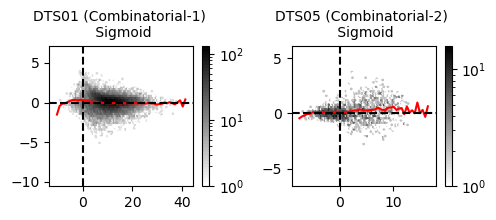

In [23]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2))

fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

#fig.supxlabel('Observed phenotype')
#fig.supylabel('Predicted phenotype')

curr_transformation = 'Sigmoid'

curr_phenotype = '1' # DTS01 aka Combinatorial-1

curr_predictions_all = predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order']

curr_predictions = curr_predictions_all[curr_predictions_all['phenotype'] == curr_phenotype]

plot_residuals_multiplot_with_smoothed_average(curr_predictions,
                                run_key='Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order',
                                axis=ax1, phenotype=curr_phenotype,
                                 Title = 'DTS01 (Combinatorial-1) \n ' + curr_transformation)
        
    
curr_phenotype = '2' # DTS05 aka Combinatorial-2

    
curr_predictions = curr_predictions_all[curr_predictions_all['phenotype'] == curr_phenotype]
plot_residuals_multiplot_with_smoothed_average(curr_predictions,
                                run_key='Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order',
                                axis=ax2, phenotype=curr_phenotype,
                                 Title = 'DTS05 (Combinatorial-2) \n ' + curr_transformation)

    

#plt.savefig('./figures/20240718_mochi_residuals_DTS01_DTS05.pdf',
#           bbox_inches = 'tight')

    
